# Final Project for Adaptive Decision Making
### Modeling Behavioral Data from Attention Decay Study with Single-boundary DDM
Group Members: Oscar, Emilio, and William

### Do all of our main imports first

In [1]:
%cd ..

/Users/oscargarcia/Desktop/ADMFinal


In [2]:
from __future__ import division
from ADMCode import visualize as vis

import numpy as np
import pandas as pd
import numba as nb

from numba.decorators import jit
from numpy.random import random_sample
from numba import float64, int64, vectorize, boolean

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

### Create a single decision barrier DDM

In [3]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_ddm(parameters, rProb, trace):

    # extract parameters
    a, tr, v, z, si, dx, dt = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

### Background code for running DDM and generating dataframes

In [4]:
def gen_ddm_storage_objects(parameters, ntrials=200, deadline=1.5):
    dt = parameters[-1]
    ntime = np.int(np.floor(deadline / dt))
    data = np.zeros((ntrials, 2))
    rProb = random_sample((ntrials, ntime))
    traces = np.zeros_like(rProb)
    return data, rProb, traces

def clean_output(data, traces, deadline=1.2, stimulus=None):
    df = pd.DataFrame(data, columns=['rt', 'choice'])
    df.insert(0, 'trial', np.arange(1, 1+df.shape[0]))
    df = df[(df.rt>0)&(df.rt<deadline)]
    traces = traces[df.index.values, :]
    df = df.reset_index(drop=True)
    return df, traces

@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        data[t, :] = sim_ddm(parameters, rProb[t], traces[t])

def sim_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

### Set our parameters
We can begin with a regular DDM (with one boundary) and tweak with the parameters or potentially add more parameters to get this best fit to the behavioral data that we have

In [5]:
a = .09 # boundary height
v = .25 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 2 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 100 # number of trials to simulate



parameters = np.array([a, tr, v, z, si, dx, dt])

In [6]:
df, traces = sim_ddm_trials(parameters, ntrials, deadline)
df.head()

,trial,rt,choice
0,1,0.399,1.0
1,2,0.264,1.0
2,3,0.309,1.0
3,4,0.463,1.0
4,5,0.280,1.0


In [7]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()
y,x = df.shape
count = 0 
print(y)


while count <y:

    df["rt"][count] =  (df["rt"][count])
    
    count+=1


print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

100
RT (cor) = 448 ms
Accuracy = 100%


In [8]:
df # after running all, calling the df value up here defaults to the last assigned value for df in the whole notebook

,trial,rt,choice
0,1,0.399,1.0
1,2,0.264,1.0
2,3,0.309,1.0
3,4,0.463,1.0
4,5,0.280,1.0
5,6,0.719,1.0
6,7,0.262,1.0
7,8,0.492,1.0
8,9,0.539,1.0
9,10,0.461,1.0


### Visualization of single barrier DDM

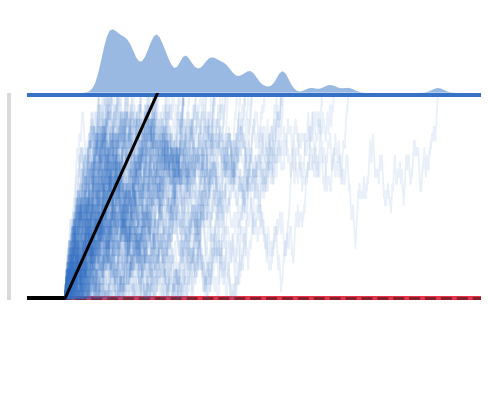

In [9]:
ax = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

In [10]:
df

,trial,rt,choice
0,1,0.399,1.0
1,2,0.264,1.0
2,3,0.309,1.0
3,4,0.463,1.0
4,5,0.280,1.0
5,6,0.719,1.0
6,7,0.262,1.0
7,8,0.492,1.0
8,9,0.539,1.0
9,10,0.461,1.0


### Create a single decision barrier DDM with attention decay

In [11]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_decay_ddm(parameters, rProb, trace):
    # extract parameters
    a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        # always add in decay parameter
        evidence -= decay
            
        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

### Background code for running decay DDM and generating dataframes

In [12]:
@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_decay_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters
        decay += decay_acceleration
        parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])
        data[t, :] = sim_decay_ddm(parameters, rProb[t], traces[t])

def sim_decay_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_decay_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

In [13]:
a = .15 # boundary height
v = .40 # strong drift-rate
tr = 0 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 5 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 1000 # number of trials to simulate
decay = 0.000005
decay_acceleration = 0.0001


parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])


In [14]:
df, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
# which code is this calling? The sim_decay function above? or is there one in the ddm.py file?
# It seems to not return values for the data frame


In [15]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()

print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

RT (cor) = 350 ms
Accuracy = 100%


In [16]:
df # gets overwritten into nothing?


,trial,rt,choice
0,1,0.477,1.0
1,2,0.314,1.0
2,3,0.383,1.0
3,4,0.348,1.0
4,5,0.247,1.0
5,6,0.392,1.0
6,7,0.280,1.0
7,8,0.242,1.0
8,9,0.308,1.0
9,10,0.431,1.0


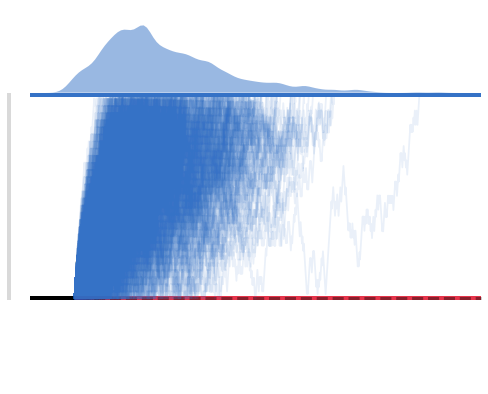

In [17]:
bx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=False)

## Model Accuracy Estimation
Now that we've created a single boundary DDM capable of producing simulated Reaction Time distribution, we want to begin manipulating its parameters to fit it to our experimental data. In order to do that in a principled way, however, we need a way of measuring if a particular set of parameters produces a better fit on the experimental data than another set of parameters. For this we will use a Chi Square 'goodness of fit' test. 

#### TODO: $$Formula For Chi Square Goes Here$$ 

The goal for our model is to minimize the value of the Chi Square, as it represents the likelihood that the distribution produced by the model is the same distribution from the experimental data.

### Chi Square to Calculate Goodnes of Fit
At a conceptual level, we are comparing how closely the observed (experimental) data matches the expected (simulation) data. We calculate the probability of any differences between the datasets being present, if they are indeed sampled from the same distribution. 

#### TODO: Visualization of Observed vs Expected distribution, can use lecture slides



+ **Note** here, that because we are using a single output of the model simulation, a model that inherently has a high variance between Simualtion instances can have significantly different $\chi^2 $ value depending on which instance we use calculate this statistic. As such, averaging the distributions between simulations of such a model increases reliability. 

### 'Bucketing' the data
For us to be able to calculate the $\chi^2$ fit we need to choose RT intervals within which to 'bucket' data points. Intuitively, the more fine-grained the buckets, the snugger the fit. But there is a catch. For this calculation to have statistical validity we must have at least 5 data points within each bucket. While this is not a problem for simulation data, it is a limitation for our experimental data since we only have so many trials. 

This is a key constraint that has downstream effects on what we choose to model and what comparisons we draw. Particularly, individual subject modeling now becomes a challnge, as we only have 47 data points for the entire experiment (3 for the pre-test period, 41 for the experimental period, and 3 for the post-test period). This is mostly due to flaws in the experimental design, and of course, the researchers have no clue that the data was going to be modeled in this way. 

#### TODO: Present our RT intervals and the rationale/process for arriving at them 



### The actual algorithm for calculating the goodness of fit
Special thanks to Wikipedia, Khan Academy and Tim and Kyle for the surprinsingly informative vizualization of the $\chi^2$ estimation on the DDM lecture slides. 

1. Define the buckets for your RT intervals. 
2. Collect your data points into the buckets. Do this for the experimental data and the simulated data (using the same intervals for both data sets).  
3. Count the Data points inside the intervals to make sure there is more than 5 in each bucket (Large Counts condition)
4. For each interval calculate $(observed counts - expected counts)/expected counts$, and then sum them all to calculate the Chi Square of your model. 
$$ \chi^s = SumFormulaHere $$
5. Get the degrees of freedom of this Chi Square distribution by subtracting one from your number of buckets. 
6. Compare your Chi Square against the critical Chi Square values for different values of $\alpha$. They represent the likelihood that your simulated and observed data come from the same distribution. 
    * There is a $\alpha$ percent chance that if the two datasets come from the same distribution, their differences would be what they are or more extreme



In [19]:
# code for chi square model fit statistic here. 

In [36]:
import math

def stdDev(mean,L):
    Sum = 0
    for i in L: 
        Sum+=math.pow((i-mean),2)
    return math.sqrt((Sum/len(L)))


def bucketer(mean,stdD,n):
    conMax = 3 #confidence rating 
    n = math.sqrt(n)
    bucket = []
    low = -1*conMax
    high = conMax+1 
    for i in [j for j in range(low,high)]:
        term = mean + i*(stdD/n)
        bucket.append(term)
    return bucket


def bucketCount(L,buckets):
    
    
           
def stats(panDf): 
    y,x = panDf.shape
    Sum = 0
    count =0
    new = []
    while count<y:
        #print(count,y)
        ind = panDf["rt"][count]
        Sum+= ind
        new+=[ind]
        count+=1
    mean = Sum/count
    std = stdDev(mean,new)
    #print(len(new))
    n = len(new)
    buck = bucketer(mean,std,n)
    bc = bucketCount(new,buck)
    return mean,std,buck

# mean,std,buckets =stats(data)

In [37]:
testM,testD,testB = stats(df)
print(testB)

[0.3375941179024211, 0.34179941193494723, 0.3460047059674734, 0.3502099999999995, 0.35441529403252564, 0.3586205880650518, 0.36282588209757793]


In [52]:
import pandas as pd
dataPath = "data/RTData.csv"
data = pd.read_csv(dataPath, header = 0)
data = data.dropna()

dataWhole = data[data.isFreq == 1]
dataisV = dataWhole[dataWhole.isVar==1]
dataisNV = dataWhole[dataWhole.isVar==0]
def changeD(rData): 
    rRT = "clickDelay"
    rt = "rt"
    trial = []
    newRT = []
    newCh = []
    dShape,garb = rData.shape
    trial = [i for i in range(dShape)]
    newRT = list(rData[rRT])

    newCh = [1 for i in range(dShape)]
    newDf = {"trial":trial,"rt":newRT,"choice":newCh}
    return pd.DataFrame(data = newDf)
dataAll,dataVar,dataNVar = changeD(dataWhole),changeD(dataisV),changeD(dataisNV)

In [53]:
dataAll

,trial,rt,choice
0,0,0.805561,1
1,1,0.927032,1
2,2,1.018496,1
3,3,1.216235,1
4,4,1.230659,1
5,5,1.232609,1
6,6,1.237245,1
7,7,1.241269,1
8,8,1.288053,1
9,9,1.304717,1


In [69]:
def isInBounds(lower, upper, value):
    return lower <= value and value <= upper

def getBuckets(bounds, dataframe):
    bucketDict = dict() # dictionary mapping bucket number to counts in the bucket
    bounds.sort()
    boundsList = [] # [(lower1, upper1), (lower2, upper2) ...]
    for i,bound in enumerate(bounds):
        if i == 0:
            boundsList.append((0, bound))
            bucketDict[i] = 0
        else:
            boundsList.append((bounds[i-1], bound))
            bucketDict[i] = 0 
        #add right tail end bucket
        if i == len(bounds) - 1:
            boundsList.append((bound, 100)) #100 is a catchAll 
            bucketDict[i + 1] = 0
            
    #print(dataframe.shape)
    for i,(lower, upper) in enumerate(boundsList):
        for rt in dataframe.rt.values:
            if isInBounds(lower, upper, rt):
                bucketDict[i] += 1
    return bucketDict

obsvMean,obsvDev,obsvBuck = stats(dataAll)

simBucketCount = getBuckets(testB, df)
obsvBucketCount = getBuckets(obsvBuck, dataAll)

print("simulated buckets: \n", simBucketCount)
print("experimental buckets: \n", obsvBucketCount)


simulated buckets: 
 {0: 541, 1: 13, 2: 12, 3: 12, 4: 16, 5: 12, 6: 9, 7: 385}
experimental buckets: 
 {0: 238, 1: 7, 2: 10, 3: 8, 4: 9, 5: 11, 6: 6, 7: 127}


In [ ]:
## calculate Chi squares
import scipy, scipy.stats

observed_values=scipy.array([18,21,16,7,15])
expected_values=scipy.array([22,19,44,8,16])


stat, pvalue = scipy.stats.chisquare(observed_values, f_exp=expected_values)
print(stat)
print(pvalue)